In [53]:
import networkx as nx
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import linkcom

## Graph Building Functions

In [54]:
def add_update_edge(G,n1,n2):
    #Add a new edge or add weight to the existing edge
    if str(n1) in G[n2]:
        G[n1][n2]['weight'] += 1
    else:
        G.add_edge(n1, n2, weight = 1)
    return(G)

In [55]:
def add_update_node(G,n,n_type):
    #Add a new node or add weight to the existing node
    if n in G:
        G.node[n]['node_weight'] += 1
    else:
        G.add_node(n, node_type = n_type, node_weight = 1)
    return(G)

In [56]:
def build_attribute_graph(df, attributes):
    #define new graph, add nodes from attribute values in dataframe df, add links between values in the same row
    G = nx.Graph()
    for row, data in df.iterrows():
        for k in attributes:
            #add nodes and node types
            if not data[k] is np.nan:
                add_update_node(G, str(data[k]), k)
        for k in attributes:      
            #add links and weights for each co-occurring pair of attributes
            for j in attributes:
                if (j > k) and (not data[j] is np.nan) and (not data[k] is np.nan):
                    add_update_edge(G,str(data[j]),str(data[k]))
    return(G)

In [57]:
def upd_node_type(G, attibute_list, category):
    for x in G.nodes.data():
        if (x[1]['node_type'] in list(attibute_list)):
            x[1]['node_type'] = category    

## Fitabase graph analysis
### Read in fitabase spreadsheet data

In [58]:
columns = ['title', 'author', 'year', 'journal', 'effect', 'condition', 'factor_1', 'factor_2', 'factor_3', 'factors_combined', 'health_1', 'health_2', 'demographic']
fitabase = pd.read_csv('fit3.csv', header = None, names = columns)

In [59]:
#Filter out entries that have Additional Factors used along with Fitbit
fit_factors = fitabase[fitabase['condition'] == 'A']

In [60]:
fit_factors.head(2)

,title,author,year,journal,effect,condition,factor_1,factor_2,factor_3,factors_combined,health_1,health_2,demographic
1,"Go4Life exercise counseling, accelerometer fee...","Thompson, W.G., Kuhle, C.L., Koepp, G.A., McCr...",2014,Archives of Gerontology and Geriatrics,1,A,Coaching,NaN,NaN,Coaching,Overweight,NaN,Older Adults
3,Enhancing physical activity promotion in midli...,"Butryn, M.L., Arigo, D., Raggio, G.a., Colasan...",2014,Journal of Health Psychology,2,A,Coaching,NaN,NaN,Coaching,Healthy,NaN,Women


### Call function to build a graph of co-occuring values for selected attributes

In [61]:
fit_attributes = ['factor_1', 'factor_2', 'factor_3', 'health_1', 'health_2', 'demographic']
fit_graph = build_attribute_graph(fit_factors, fit_attributes)
print(nx.info(fit_graph))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 129
Average degree:   6.7895


In [62]:
#Combine attributes into node types
upd_node_type(fit_graph, ['health_1','health_2'], 'health')
upd_node_type(fit_graph, ['factor_1', 'factor_2', 'factor_3'], 'factor')

#### demonstrating query neighbors in a graph

In [97]:
for n in fit_graph.neighbors('Diabetes'):
    print(n)

Obese
Social Support
Adults
Coaching
Web App


In [102]:
[n for n in fit_graph.neighbors('Diabetes')]

['Obese', 'Social Support', 'Adults', 'Coaching', 'Web App']

#### draw the graph

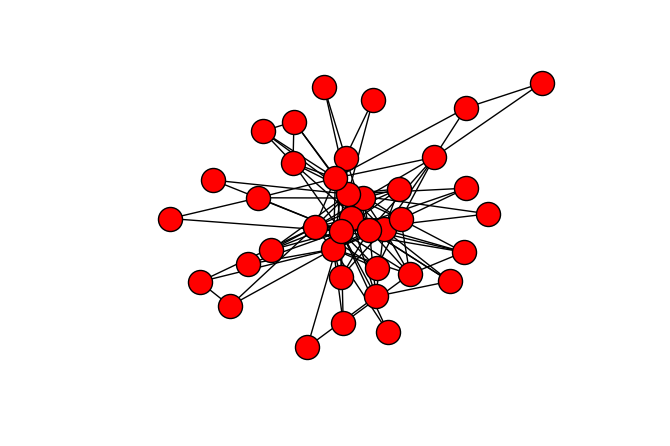

In [63]:
nx.draw(fit_graph, with_labels = False)

Graph visualization shows a dense core and many periphery nodes

### Derive network properties - link community detection

In [65]:
def num_of_partitions(dict):
    #derive number of unique values in a dictionary
    partitions = []
    for v in dict.values():
        if v not in partitions:
            partitions.append(v)
    return(len(partitions))

In [64]:
#determine link community clusters
e2c, S, D, Dlist = linkcom.cluster(fit_graph)

clustering...
computing similarities...
# D_max = 0.303950
# S_max = 0.466667


In [71]:
#find number of link communities in the edge-to-community dictionary
print("Number of partitions:",num_of_partitions(e2c))

# Make new link communities attributes of the graph
nx.set_edge_attributes(fit_graph, e2c, "linkcom")

Number of partitions: 42


In [72]:
# Write detailed graph with 42 partitions
nx.write_gexf(fit_graph, 'fit_graph_42.gexf')

## Build dendrogram of link communities to determine the threshold levels of community detection algorithm that controls granulatiry

In [67]:
e2c_1, S_1, D_1, Dlist_1, e2c_orig, dendro = linkcom.cluster(fit_graph, dendro_flag = True)

clustering...
computing similarities...
# D_max = 0.303950
# S_max = 0.466667


In [68]:
d_levels = []
for d in dendro:
    if d[2] not in d_levels:
        d_levels.append(d[2])
print("Number of levels:", len(d_levels), "\n", d_levels)

Number of levels: 36 
 [1.0, 0.8333333333333334, 0.75, 0.7142857142857143, 0.6111111111111112, 0.6, 0.5882352941176471, 0.5789473684210527, 0.5555555555555556, 0.5333333333333333, 0.5, 0.47619047619047616, 0.46875, 0.4666666666666667, 0.46153846153846156, 0.45833333333333326, 0.4545454545454546, 0.4482758620689655, 0.4444444444444444, 0.4347826086956521, 0.4285714285714286, 0.41666666666666674, 0.4, 0.38888888888888884, 0.375, 0.368421052631579, 0.36363636363636365, 0.3571428571428572, 0.3529411764705883, 0.33333333333333326, 0.30000000000000004, 0.2857142857142857, 0.2666666666666666, 0.26315789473684204, 0.2068965517241379, 0.18181818181818188]


### Try different threshold levels of community detection and compare the number of partitions

In [69]:
e2c_2, D_2 = linkcom.cluster(fit_graph, threshold = 0.4)

#find number of link communities in the edge-to-community dictionary
print("Number of partitions:", num_of_partitions(e2c_2))

# Make new link communities attributes of the graph
nx.set_edge_attributes(fit_graph, e2c_2, "linkcom")

clustering...
computing similarities...
# D_thr =  0.2510692529844378
Number of partitions: 19


In [70]:
e2c_2, D_2 = linkcom.cluster(fit_graph, threshold = 0.36)

#find number of link communities in the edge-to-community dictionary
print("Number of partitions:", num_of_partitions(e2c_2))

# Make new link communities attributes of the graph
nx.set_edge_attributes(fit_graph, e2c_2, "linkcom")

clustering...
computing similarities...
# D_thr =  0.20987003729585937
Number of partitions: 11


### Write to external file for Gephi visualization
#### Run Gephi modularity algorithm to explore node communities
#### Use Gephi to visualize link community using edge attribute 'linkcom'

In [46]:
# Write coarse graph with 19 partitions
nx.write_gexf(fit_graph, 'fit_graph_19.gexf')

## More functions to drill down in community details: list edges, find top nodes

In [92]:
def list_edges(e2c_dictionary):
    #list edges per link community
    communities = {}
    for i in e2c_dictionary.items():
        if i[1] not in communities:
            edges = []
            edges.append(i[0])
            communities[i[1]] = edges
        else:
            communities[i[1]].append(i[0])
    return(communities)

In [76]:
def find_top_2_nodes(community):
    #find node in the link community with most local links within the community
    community_nodes = {}
    edges = community[1]
    for edge in edges:
        for node in edge:
            if node in community_nodes:
                community_nodes[node] += 1
            else:            
                community_nodes[node] = 1
    num_nodes = len(community_nodes)
    max_value = np.max(list(community_nodes.values()))
    top_2_nodes = []
    for item, value in community_nodes.items():
        if value == max_value:
            top_2_nodes.append(item)
    return(top_2_nodes[:2], max_value, num_nodes, list(community_nodes.keys()))

In [93]:
def build_edge_df(e2c_dictionary):
    #store link communities in a dataframe, identify top nodes and sort according to community strength
    communities = pd.DataFrame()
    top_nodes = []
    max_values = []
    number_nodes = []
    node_names = []
    for community in list_edges(e2c_dictionary).items():
        top_2_nodes, max_value, num_nodes, nodes = find_top_2_nodes(community)
        top_nodes.append(top_2_nodes)
        max_values.append(max_value)
        number_nodes.append(num_nodes)
        node_names.append(nodes)
    communities['top nodes'] = top_nodes
    #communities['max_value'] = max_values
    communities['number of nodes'] = number_nodes
    communities['community nodes'] = node_names
    communities['community links'] = list_edges(e2c_dictionary).values()
    communities.sort_values(by = 'number of nodes', ascending = False, inplace = True)
    return(communities)

In [95]:
#Build dataframe from the Fitabase graph
fit_communities_19 = build_edge_df(e2c_2)

In [94]:
#Build dataframe from the Fitabase graph
fit_communities_42 = build_edge_df(e2c)
fit_communities_42

,top nodes,number of nodes,community nodes,community links
19,"[Gamification, Obese]",8,"[Gamification, Obese, Adults, Coaching, Messag...","[(Coaching, Women), (Gamification, Messaging),..."
29,[Personal Training],8,"[Obese, Ovarian Cancer, Coaching, Men, Messagi...","[(Messaging, Personal Training), (Obese, Perso..."
38,[Healthy],7,"[Gamification, Healthy, Coaching, Messaging, W...","[(Adults, Healthy), (Healthy, Women), (Healthy..."
33,[Social Support],6,"[Obese, Social Support, Coaching, Overweight, ...","[(Adults, Social Support), (Overweight, Social..."
14,[Young Adults],6,"[Obese, Gamification, Young Adults, Coaching, ...","[(Overweight, Young Adults), (Obese, Twitter),..."
2,[Support Group],5,"[Support Group, Women, Adults, Coaching, Overw...","[(Coaching, Support Group), (Adults, Support G..."
40,[Mobile App],5,"[Obese, Women, Coaching, Mobile App, Overweight]","[(Mobile App, Obese), (Mobile App, Overweight)..."
5,[Breast Cancer],5,"[Messaging, Breast Cancer, Web App, Coaching, ...","[(Breast Cancer, Messaging), (Breast Cancer, W..."
9,[Adolescents],5,"[Obese, Adolescents, Messaging, Web App, Overw...","[(Adolescents, Obese), (Adolescents, Overweigh..."
16,"[Cardiometabolic Risk, Adults]",4,"[Cardiometabolic Risk, Adults, Coaching, Knee ...","[(Adults, Cardiometabolic Risk), (Cardiometabo..."


## Write community details to an external file

In [49]:
fit_communities_19.to_csv('fit_communities_19.csv', index = False)

In [88]:
fit_communities_42.to_csv('fit_communities_42.csv', index = False)